## IMPORT DEPENDENCIES

In [1]:
import os
import cv2
import shutil
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DIRECTORY

In [4]:
train_dir = "/content/drive/MyDrive/AI ML/PROJECTS/DRIVER DROWSINESS DETECTION/DATA COLLECTION/Processed Image/data/train"
os.listdir(train_dir)

['Closed', 'Open']

In [ ]:
# def preprocess(path):
#     for image_path in glob(path + '/*'):
#         base_name = os.path.basename(image_path)
#         image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
#         face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#         faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
#         for (x, y, w, h) in faces:
#             img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
#             roi_color = img[y:y+h, x:x+w]
#             cv2.imwrite(f"{os.path.join(path, base_name)}", roi_color)
   

In [5]:
img_width = img_height = 160
seed = 42
batch_size = 32

train_ds = image_dataset_from_directory(train_dir,
                                        label_mode = 'int',
                                        batch_size = batch_size,
                                        image_size = (img_width, img_height),
                                        color_mode = 'rgb',
                                        labels = "inferred",
                                        shuffle = True,
                                        validation_split=0.2,
                                        subset = "training",
                                        seed = seed)

validation_ds = image_dataset_from_directory(train_dir,
                                        label_mode = 'int',
                                        batch_size = batch_size,
                                        image_size = (img_width, img_height),
                                        color_mode = 'rgb',
                                        labels = "inferred",
                                        shuffle = True,
                                        validation_split=0.2,
                                        subset = "validation",
                                        seed = seed
                                        )


Found 1452 files belonging to 2 classes.
Using 1162 files for training.
Found 1452 files belonging to 2 classes.
Using 290 files for validation.


In [6]:
class_names = train_ds.class_names
class_names

['Closed', 'Open']

In [7]:
def plot_images(images, labels, class_names):
  plt.figure(figsize=(10, 10))
  for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

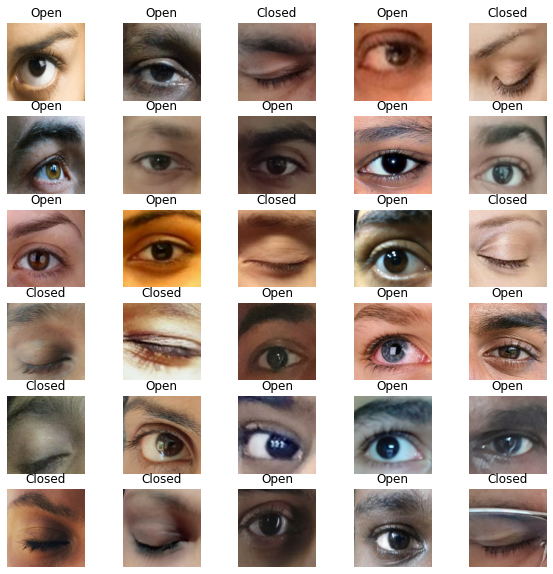

In [8]:
img_batch, label_batch = next(iter(train_ds))
plot_images(img_batch, label_batch, class_names)

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model.
Dataset.prefetch overlaps data preprocessing and model execution while training.
we use buffered prefetching so we can yield data from disk without having I/O become blocking.


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(AUTOTUNE)

### Data Augmentation

Note: These layers are active only during training, when you call Model.fit. They are inactive when the model is used in inference mode in Model.evaluate or Model.predict

In [10]:
# def augment(image, label):
#     image = tf.image.resize(image, [img_width, img_height])
#     image = tf.image.random_crop(image, [img_width, img_height, 3])
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, 0.1)
#     image = tf.image.random_saturation(image, 0.1, 2.0)
#     image = tf.image.random_hue(image, 0.1)
#     image = tf.image.random_contrast(image, 0.1, 2.0)
#     return image, label

def augment_img():
    aug = Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2)
    ])

    return aug

data_augmentation = augment_img()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


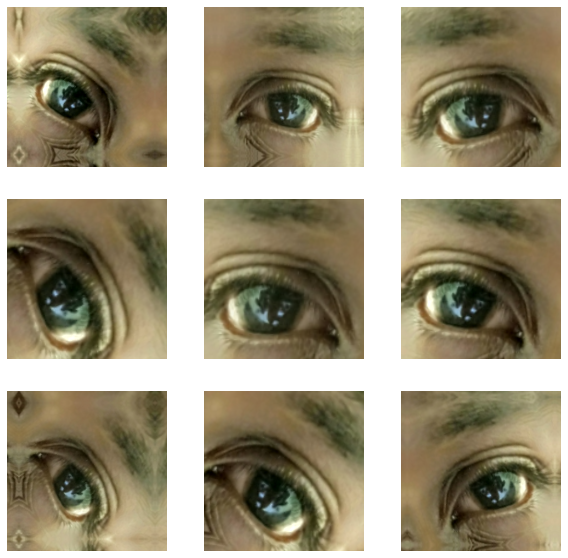

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Creating Base Model

In [12]:
base_model = MobileNetV2(input_shape=(img_width, img_height, 3),\
                        include_top=False, weights='imagenet')

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

# Create Model with Fucntional API

In [14]:
img_inputs = Input(shape=(img_width, img_height, 3))
aug_img = data_augmentation(img_inputs)
preprocess_img = preprocess_input(aug_img)
b_model = base_model(preprocess_img, training=False)
global_avg_pool = GlobalAveragePooling2D()(b_model)
dropout = Dropout(0.2)(global_avg_pool)
output = Dense(1)(dropout)
model = Model(inputs=img_inputs, outputs=output)

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
37/37 [==============================] - 224s 6s/step - loss: 0.9085 - accuracy: 0.4552 - val_loss: 0.7916 - val_accuracy: 0.4724
Epoch 2/10
37/37 [==============================] - 2s 66ms/step - loss: 0.7519 - accuracy: 0.5602 - val_loss: 0.6193 - val_accuracy: 0.6000
Epoch 3/10
37/37 [==============================] - 2s 65ms/step - loss: 0.5849 - accuracy: 0.6928 - val_loss: 0.4936 - val_accuracy: 0.7172
Epoch 4/10
37/37 [==============================] - 2s 66ms/step - loss: 0.4767 - accuracy: 0.7788 - val_loss: 0.4044 - val_accuracy: 0.8379
Epoch 5/10
37/37 [==============================] - 2s 65ms/step - loss: 0.4183 - accuracy: 0.8150 - val_loss: 0.3364 - val_accuracy: 0.8862
Epoch 6/10
37/37 [==============================] - 2s 66ms/step - loss: 0.3549 - accuracy: 0.8528 - val_loss: 0.2872 - val_accuracy: 0.9241
Epoch 7/10
37/37 [==============================] - 2s 65ms/step - loss: 0.2989 - accuracy: 0.8959 - val_loss: 0.2502 - val_accuracy: 0.9379
Epoch 8/10
37

Text(0.5, 1.0, 'Training and Validation Loss')

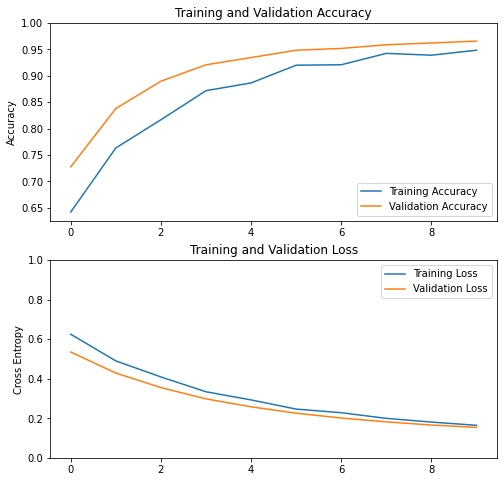

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

### Model Fine Tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.


In [ ]:
# Unfreeze the top layers of the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


### Recompile the model 

Since we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, the model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),\
         optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), \
            metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training the model from last point

In [ ]:
history_fine = model.fit(train_ds, epochs=20, \
    initial_epoch=history.epoch[-1], validation_data=validation_ds)

Epoch 10/20
37/37 [==============================] - 12s 127ms/step - loss: 0.0627 - accuracy: 0.9836 - val_loss: 0.0274 - val_accuracy: 0.9897
Epoch 11/20
37/37 [==============================] - 4s 98ms/step - loss: 0.0298 - accuracy: 0.9880 - val_loss: 0.0267 - val_accuracy: 0.9931
Epoch 12/20
37/37 [==============================] - 4s 95ms/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: 0.0150 - val_accuracy: 0.9966
Epoch 13/20
37/37 [==============================] - 3s 95ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 0.0154 - val_accuracy: 0.9966
Epoch 14/20
37/37 [==============================] - 4s 96ms/step - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0.0125 - val_accuracy: 0.9966
Epoch 15/20
37/37 [==============================] - 3s 95ms/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.0136 - val_accuracy: 0.9966
Epoch 16/20
37/37 [==============================] - 3s 95ms/step - loss: 0.0068 - accuracy: 0.9966 - val_loss: 0.0108 - val_accuracy: 0.9966
Epoc

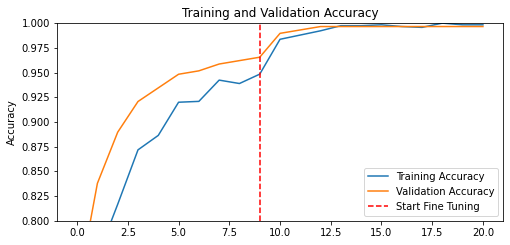

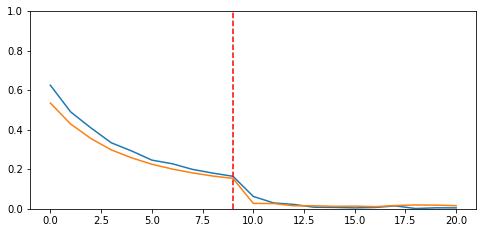

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8,1])
plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), color='red', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), color='red', linestyle='--', label='Start Fine Tuning')

In [ ]:
loss, accuracy = model.evaluate(validation_ds)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

10/10 [==============================] - 1s 54ms/step - loss: 0.0156 - accuracy: 0.9966
Test Loss: 0.01558662299066782, Test Accuracy: 0.9965517520904541


In [ ]:
image_batch, label_batch = next(iter(validation_ds))
predictions = model.predict_on_batch(image_batch).flatten()

In [ ]:
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions > 0.5, 1, 0)
print(f"predictions: {predictions.numpy()}, \nlabels: {label_batch}")

predictions: [0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1], 
labels: [0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1]


In [ ]:
def plot_images(images, labels, preds, class_names):
  plt.figure(figsize=(10, 10))
  for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if class_names[labels[i]] == class_names[preds[i]]:
        plt.title(class_names[preds[i]], color='green')
    else:
        plt.title(class_names[preds[i]], color='red')
    plt.axis("off")

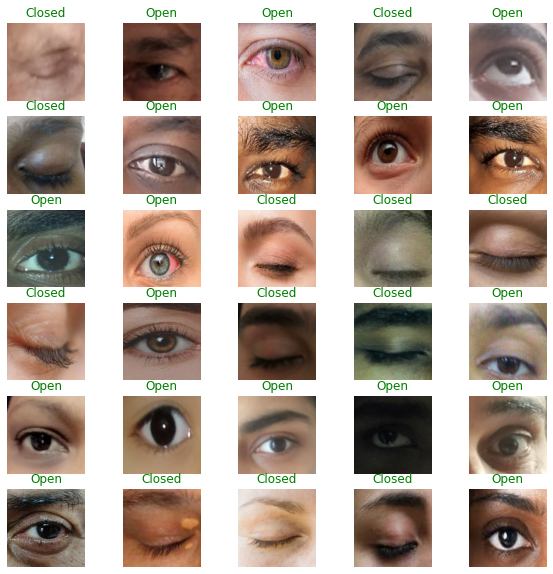

In [ ]:
plot_images(image_batch, label_batch, predictions, class_names)